# Least squares for model fitting

(9.1) **Linear least squares.** The linear least squares problem is

$$
\hat {\mathbf w} = \argmin_{\mathbf w} \lVert \mathbf X \mathbf w - \mathbf y \rVert^2. 
$$ 

Here we use the Euclidean norm. In other words, we want to find the optimal choice of parameters $\mathbf w$ such that gives the best least squares approximation of $\mathbf y$ as a linear combination of columns of $\mathbf X$, i.e. the closest point in $\mathsf{C}(\mathbf X)$ to $\mathbf y.$ 

In applications, we use objective is used to model the data as a linear system perhaps under some measurement noise. Here $\mathbf y \in \mathbb R^n$ is a sample of output values, while $\mathbf X \in \mathbb R^{n \times d}$ is a sample of $n$ input values, then $\mathbf w \in \mathbb R^d$ is the weights vector which act as parameters of the model. 

<br>

(9.2) **Solution to the LLS objective.** 
Geometrically, it is intuitive that the unique vector in $\mathsf{C}(\mathbf X)$ that minimizes the distance from $\mathbf y$ is the orthogonal projection. Observe that for any $\mathbf z \in \mathsf{C}(\mathbf X)$,
  $$
  \lVert \mathbf z - \mathbf y \rVert^2 = \lVert \mathbf z - \hat{\mathbf y} \rVert^2 + \lVert \hat{\mathbf y} - \mathbf y \rVert^2 \geq  \lVert \hat{\mathbf y} -\mathbf y  \rVert^2.
  $$   

Thus, projections are solutions to the LLS and we can take $\hat{ \mathbf w} = \mathbf X^+ \mathbf y.$ In fact, projections are the only solutions. We prove this using the singular vectors of $\mathbf X.$ The objective function in terms of the SVD can be written as
  $$
  \begin{aligned}
  \lVert \mathbf y - {\mathbf U \mathbf \Sigma} {\mathbf V}^\top \mathbf w \rVert^2
  &= \lVert {\mathbf U}^\top \mathbf y - {\mathbf \Sigma} {\mathbf V}^\top \mathbf w \rVert^2 \\ 
  &= \lVert {\mathbf U_d}^\top\mathbf y - \mathbf \Sigma_d {\mathbf V_d}^\top \mathbf w \rVert^2 + \lVert {\mathbf U_{d+1:}}^\top\mathbf y \rVert^2. 
  \end{aligned}
  $$

We ignore the second term since it does not depend on $\mathbf w$ &mdash; this is precisely the normal distance of $\mathbf y$ from $\mathsf{C}(\mathbf X).$ The unique minimal solution is obtained by setting all components of the first term zero, i.e. finding $\mathbf w$ such that ${\mathbf U_d}^\top\mathbf y = \mathbf \Sigma_d {\mathbf V_d}^\top \mathbf w.$ One such solution is
$$
\begin{aligned}
\hat {\mathbf w} 
  = \sum_{k=1}^r \frac{1}{\sigma_k} \boldsymbol v_k \boldsymbol u_k^\top \mathbf y 
  = \mathbf V \mathbf \Sigma^+ \mathbf U^\top \mathbf y = \mathbf X^+ \mathbf y.
\end{aligned}
$$

Note that there is gap of $d - r$ right singular vectors that get zeroed out by $\mathbf \Sigma^+.$ So the most general solution is $\hat {\mathbf w} = \mathbf X^+ \mathbf y + \sum_{j = r+1}^d \alpha_j \mathbf v_j$ 
for parameters $\alpha_j \in \mathbb R.$ If the columns are independent, then there is a unique optimal weight. Otherwise, the optimal weights occupy an affine space of $d - r$ dimensions!

<br>


(9.3) **Linear least squares via gradient descent.** Note that the least squares objective can be written as 

$$
J(\mathbf w) = \frac{1}{n}\sum_{i=1}^n \left( \sum_{j=1}^d x_{ij} w_j - y_i \right)^2.
$$

This is essentially a shallow neural network with identity activation with MSE loss! Then, we can solve this using SGD or batch GD with the gradient step
$$
\nabla_k J (\mathbf w) = \frac{2}{n} \sum_{i=1}^n \left( \sum_{j=1}^d x_{ij} w_j - y_i \right) x_{ik}.
$$

We will use this to update $\mathbf w = \mathbf{w} - \eta\;\nabla J$ for some fixed learning rate $\eta > 0.$ For each iteration, the weights $\mathbf w$ move to some (locally) optimal weight that minimizes the objective $J.$ For a linear model with nonzero bias term $w_0$, we can set $x_{i0} = 1.$

<br>

(9.4) **Code demo: gradient descent with LLS loss.** In `src/11_leastsquares_descent.py`, we perform gradient descent on a synthetic dataset. For simplicity, i.e. so we can plot, we model the signal $y = -1 + 3 x$ where $x \in [-1, 1]$ and with some Gaussian measurement noise:

* `X[:, 0] = 1`
* `X[:, 1] = np.random.uniform(low=-1, high=1, size=n)`
* `y = X @ w_true + 0.01*np.random.randn(n)` 

where `w_true = np.array([-1, 3])`. The gradient step can be vectorized as follows:

```python
2*((X @ w - y) * X[:, k]).mean()
``` 

for each `k`. Further vectorization requires broadcasting: 

```python
2*((X @ w - y).reshape(-1, 1) * X).mean(axis=0)
```
i.e. multiplies `X @ w - y` to each column of `X` followed by taking the mean of each column. This gives us the gradient vector of length 2. Let us see whether gradient descent can find `w_true`.

MSE(y, X @ w_true) = 9.343257744523987e-05
MSE(y, X @ w_best) = 0.014467391595319783
MSE(y, X @ X_pinv @ y) = 9.326870244717224e-05
w_true = [-1  3]
w_best = [-1.00332668  2.79325696]
X_pinv @ y = [-0.99971352  2.99951481]


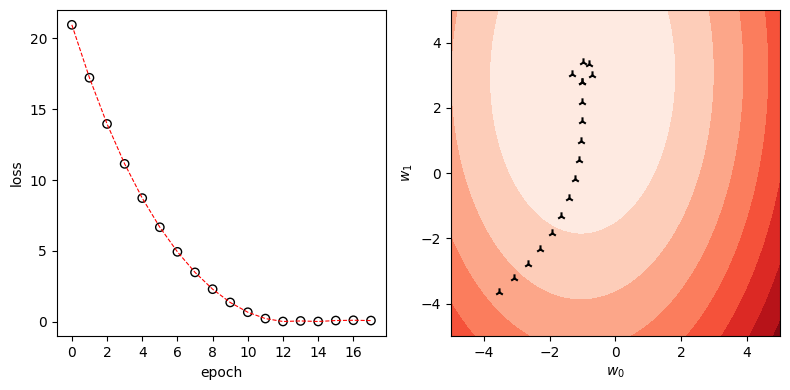

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
np.random.seed(0)

def loss(w, X, y):
    '''linear least square loss'''
    return ((X @ w - y)**2).mean()

def grad(w):
    '''gradient step for the lls loss function'''
    # 2*((X @ w - y) * X[:, k]).mean() for each k -> broadcast
    dw = 2*((X @ w - y).reshape(-1, 1) * X).mean(axis=0)
    return dw / np.linalg.norm(dw)

# Generate noisy sample data
n = 1000
X = np.zeros((n, 2))
X[:, 1] = np.random.uniform(low=-1, high=1, size=n)
X[:, 0] = 1
w_true = np.array([-1, 3])
y = (X @ w_true) + 0.01 * np.random.randn(n)      # signal: y = -1 + 3x + noise
assert loss(w_true, X, y) < 0.001                       # without noise, J(-1, 3) = 0

# Gradient descent
w = np.array([-4, -4], dtype=np.float64)
epochs = 18
eta = 0.6
w_hist = np.zeros(shape=[epochs, 2]) 
loss_hist = []
for _ in range(epochs):
    w -= eta * grad(w)
    w_hist[_, :] = w 
    loss_hist.append(loss(w, X, y))

# Contour plot
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
N = 200 # size of grid
row = np.linspace(-5, 5, N)
XX, YY = np.meshgrid(row, row)
ZZ = np.zeros_like(XX)
for i in range(N):
    for j in range(N):
        ZZ[i, j] = loss(np.array([XX[i, j], YY[i, j]]), X, y)

# Plot steps on gradient
ax[1].contourf(XX, YY, ZZ, cmap='Reds')
ax[1].scatter(w_hist[:, 0], w_hist[:, 1], marker='2', facecolors='k')
ax[1].set_xlabel(f'$w_0$')
ax[1].set_ylabel(f'$w_1$')

# Plot loss history
ax[0].plot(loss_hist, linestyle='--', c='red', linewidth=0.8)
ax[0].scatter(list(range(epochs)), loss_hist, marker='o', facecolors='None', edgecolors='k')
ax[0].set_ylabel(f'loss')
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[0].set_xlabel(f'epoch')

fig.tight_layout()

# Check with pinv
w_best = w_hist[np.argmin(loss_hist)]   
print('MSE(y, X @ w_true) =', ((y - X @ w_true)**2).mean())
print('MSE(y, X @ w_best) =', ((y - X @ w_best)**2).mean())
print('MSE(y, X @ X_pinv @ y) =', ((y - X @ np.linalg.pinv(X) @ y)**2).mean())
print('w_true =', w_true)
print('w_best =', w_best)
print('X_pinv @ y =', np.linalg.pinv(X) @ y)

Here `w_best` is the best weight found using GD. The analytic solution obtained using the pseudoinverse performs better. Try to experiment with the code, e.g. changing the signal to be quadratic (nonlinear) to see how the loss surface will change. It will still be convex, since only the data changes. However, it does not anymore minimize to an MSE proportional equal to the square of the amplitude $a$ of the noise. To derive this, observe that since $\mu = 0$, the variance is $\mathbb E[a^2 X^2] = a^2 \mathbb E[X^2] = a^2\sigma^2 = a^2.$ This agrees with the best MSE of `9.34e-05` ~ `1e-4`. This can be derived analytically by writing the loss function as 
$(\mathbf y - \mathbf X \mathbf w)^\top (\mathbf y - \mathbf X \mathbf w).$ If we substitute $\mathbf y = \mathbf X \mathbf w_{\text{true}} + \boldsymbol{\epsilon},$ then 

$$
J(\mathbf w) = (\mathbf w - \mathbf w_{\text{true}})^\top \mathbf X^\top \mathbf X (\mathbf w - \mathbf w_{\text{true}}) - 2 \boldsymbol{\epsilon}^\top \mathbf X (\mathbf w - \mathbf w_{\text{true}}) + \boldsymbol{\epsilon}^\top\boldsymbol{\epsilon}. 
$$

This is a quadratic surface centered at $\mathbf w_{\text{true}}$ with value $J = \boldsymbol{\epsilon}^\top\boldsymbol{\epsilon}$ at the minimum $\mathbf w = \mathbf w_{\text{true}}.$

<br>


(9.5) **Loss surfaces.** If $\mathbf X$ has linearly dependent columns, we expect that the optimal weight vector $\mathbf w$ is not unique. The loss surfaces are plotted below where we plot the loss surface with $\mathbf X$ having dependent columns (top) with `X[:, 0] = 2 * X[:, 1]` &mdash; observe the whole strip of optimal weights; and the loss surface where $\mathbf X$ has independent columns with a unique optimal point (bottom). Recall that the equation for optimal weights is given by 

$$\hat{\mathbf w} = \mathbf X^+ \mathbf y + \sum_{j = r+1}^d \alpha_j \mathbf v_j$$ 

for coefficients $\alpha_j \in \mathbb R.$ In this example, $d = 2$ and $r = 1$ so the optimal weights occupy 1-dimension in the parameter space spanned by the second left singular vector $\mathbf v_2$ offset by $\mathbf w^+.$ This is implemented in the code and the optimal weights plotted as a scatterplot. (The 3D plots on the left can be moved around and inspected using `plt.show()` in the script, if you actually run the code!) Note that the optimal points are generated using the equation for the optimal weight (see code), i.e. not manually plotted. Thus, the code demonstrates uniqueness and nonuniqueness of optimal weights depending on the rank of $\mathbf X$ as well as the correctness of the equation. Interesting that the geometry of the loss surface is affected by the rank of $\mathbf X$ and affected in a tractable manner &mdash; i.e. by counting dimensions!

<br>

In [12]:
np.random.seed(0)
from mpl_toolkits import mplot3d 

def loss(w, X, y):
    '''linear least square loss'''
    return ((X @ w - y)**2).mean()

def plot_loss_surface(independent):
    # Generate noisy sample data
    n = 1000
    X = np.zeros((n, 2))
    X[:, 1] = np.random.uniform(low=-1, high=1, size=n)
    if independent:
        X[:, 0] = 1
    else: 
        X[:, 0] = 2*X[:, 1]

    w_true = np.array([-1, 3])
    y = (X @ w_true) + 0.01 * np.random.randn(n)      # signal: y = -1 + 3x + noise


    # Plot loss surface
    fig = plt.figure(figsize=(6, 3))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122)

    N = 400 # size of grid
    row = np.linspace(-5, 5, N)
    XX, YY = np.meshgrid(row, row)
    ZZ = np.zeros_like(XX)
    for i in range(N):
        for j in range(N):
            ZZ[i, j] = loss(np.array([XX[i, j], YY[i, j]]), X, y)


    # Plot 3D surface 
    ax1.plot_surface(XX, YY, ZZ, cmap='Reds') 
    ax1.set_xlabel(f'$w_0$')
    ax1.set_ylabel(f'$w_1$')

    # Plot contour and optimal weights
    ax2.contourf(XX, YY, ZZ, cmap='Reds', levels=30)
    ax2.set_xlabel(f'$w_0$')
    ax2.set_ylabel(f'$w_1$')
    u, s, vT = np.linalg.svd(X)
    r = np.count_nonzero((s > 1e-8).astype(int)) # rank of X
    d = X.shape[1]
    
    sample_size = 20
    optimal_weights = np.zeros(shape=[sample_size, d])
    optimal_weights[:, 0] = (np.linalg.pinv(X) @ y.reshape(-1, 1))[0]
    optimal_weights[:, 1] = (np.linalg.pinv(X) @ y.reshape(-1, 1))[1]
    
    alpha = np.linspace(-5, 5, sample_size)
    for j in range(r, d): # r+1, ..., d -> r, ..., d-1
        for i in range(sample_size):
            optimal_weights[i, :] = alpha[i] * vT[j, :] # see discussion

    ax2.scatter(optimal_weights[:, 0], optimal_weights[:, 1], 
                marker='o', facecolors='k', s=1)

    fig.tight_layout()
    plt.show() # can move 3d plot around

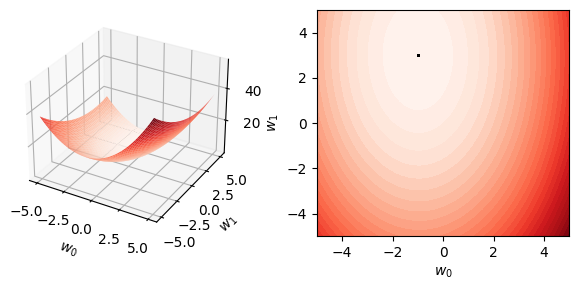

In [14]:
plot_loss_surface(independent=True)

<b>Figure.</b> Loss surface for X with independent columns; unique minimum.

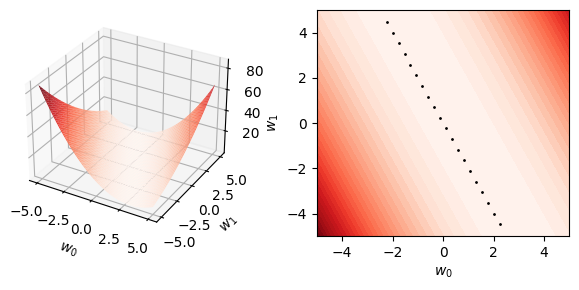

In [13]:
plot_loss_surface(independent=False)

<b>Figure.</b> Loss surface for X with dedependent columns; nonunique (1-dim) minima.